# 📺 Netflix Recommendation System Project

## **Project Overview**
In this project, we are building a **Netflix-style movie recommendation system** using real-world data. The goal is to predict **which movies a user might like** based on their past ratings and the ratings of other users.

We will focus on:

1. **Data Understanding & Cleaning**  
   - The dataset comes from the **Netflix Prize competition**, containing millions of ratings.  
   - Data is messy: movie IDs are listed separately, ratings are in text format, and there are missing or duplicate values.  

2. **Exploratory Data Analysis (EDA)**  
   - Understand the distribution of ratings.  
   - Find top-rated movies and active users.  
   - Visualize sparsity of the user-movie matrix.  

3. **Building the Recommendation System**  
   - Use **Model-based Collaborative Filtering**  technique.  
   - Implement **SVD (Singular Value Decomposition)** to handle sparse user-movie matrices.  
   - Use the **Surprise library** for easy model training, prediction, and evaluation.  

4. **Evaluation**  
   - Evaluate the model performance using **RMSE (Root Mean Squared Error)**.  
   - Test how well the system predicts ratings for unseen movies.  

5. **Generating Recommendations**  
   - Recommend top movies to a user they haven’t watched yet.  
   - Optionally, compare recommendations for multiple users.  

---

## **Key Concepts in This Project**
- **User-Item Matrix:** Table where rows are users, columns are movies, and cells are ratings.  
- **Collaborative Filtering:** Recommending movies based on **similar users**.  
- **SVD:** Reduces a large, sparse matrix into **latent factors** representing user and movie features.  
- **Surprise Library:** Python library to simplify **building and evaluating recommendation systems**.  

---

## **Why This Project is Useful**
- Real-world applications: Netflix, Amazon, Spotify, YouTube, etc.  
- Helps understand **how big tech recommends content** using user behavior.  
- Introduces **data cleaning, matrix factorization, and model evaluation** in a real dataset.  

---



### **Importing basic libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---------------

## **Data Cleaning & Transformation**

### **Fixing the parsing problem of dataset** 
The dataset lists movie IDs as a header row, followed by ratings for that movie:

| Cust\_Id | Rating |
| -------- | ------ |
| 1:       |        |
| 1488844  | 3      |
| 822109   | 5      |

#### **After fixing:**

|Movie_Id| Cust\_Id | Rating |
---------| -------- | ------ |
1        | 1488844  | 3      |
1        | 822109   | 5      |

- Movie_Id column explicitly matches each rating.
- Cust_Id column only contains actual customer IDs.
- All columns have proper datatype


- *The movie rating files contain over 100 million ratings from 480 thousand randomly-chosen, anonymous Netflix customers over 17 thousand movie titles. The combined_data_1.txt.zip is one of the fragments of the entire 100M ratings dataset. We'll only work on one fragment to avoid long training time and reduce overhead during cleaning. This one fragment has 4499 movies and ratings from about 470758 users. One user can have rated more than one movie. The entire dataset is contained in txt files and this one of the txt files.*

- *The movie_titles.csv file contains titles of all the movies wihtout duplicates*

----------

In [36]:
df = pd.read_csv('combined_data_1.txt.zip', header=None, names = ['Cust_Id', 'Rating'], usecols = [0,1]) 
df

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


In [37]:
df['Movie_Id'] =df['Cust_Id'].where(df['Cust_Id'].str.endswith(':'), pd.NA) #fetches the values with indices which fulfil the condtion & puts NA if it does not 

In [ ]:
df['Movie_Id']= df['Movie_Id'].ffill() # forward fills the empty values movie id  
df 

In [ ]:
df.dropna(inplace=True) # drops all rows with null values  

In [ ]:
df['Movie_Id']= df['Movie_Id'].str.replace(':','') #1: -> 1

In [ ]:
df = df.astype('int') #converting to int

In [9]:
df

,Cust_Id,Rating,Movie_Id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1
...,...,...,...
24058258,2591364,2,4499
24058259,1791000,2,4499
24058260,512536,5,4499
24058261,988963,3,4499


- **now all the columns are ready for analysis**

### **Sanity Check**

In [10]:
df.isnull().sum()


Cust_Id     0
Rating      0
Movie_Id    0
dtype: int64

In [11]:
df.duplicated().sum()

0

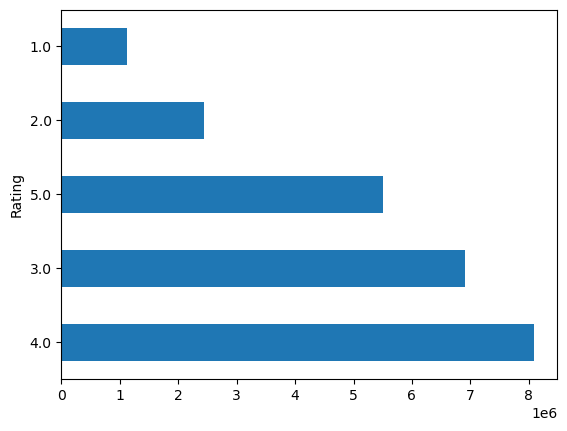

In [38]:
df['Rating'].value_counts().plot(kind='barh') #smol visualization to see the ratings count
plt.show()

In [ ]:
df['Cust_Id'].nunique() #total customers who rated without duplicates

470758

In [ ]:
df['Movie_Id'].nunique() #total movies

4499

---------

## **Training SVD model**

- *If you dont have Anaconda configured, then install it to use the conda command below. I dont know how to fix the requirement for the installation when I did with pip. So this is only way to do it wihtout hassle.*

In [15]:
# conda install -c conda-forge scikit-surprise --yes

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

### **Smol Note on SVD**

- SVD (Singular Value Decomposition) breaks a large matrix into smaller factors.
- In recommender systems:
    - User–Movie rating matrix → decomposed into latent features (hidden patterns).
    - Helps predict missing ratings by capturing user taste + movie characteristics.

In [ ]:
reader = Reader(rating_scale=(1,5)) #because our rating ranges from 1 to 5
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

In [ ]:
train, test = train_test_split(data, test_size=0.2) #80% training= 19M rows; 20% testing = 5M rows

In [ ]:
model = SVD()
model.fit(train) #will take forveer to train so this is why we didnt took the whole 100M dataset

---------------

## **Evaluation**

In [ ]:
pred = model.test(test) #predict the unseen test data

In [ ]:
accuracy.rmse(pred) 

RMSE: 0.9005


0.9005390447942934

### **Acceptable RMSE Range**

- RMSE (Root Mean Squared Error) measures how far predicted ratings are from actual ratings.
- Netflix Prize baseline was ~0.85.
- We got 0.90 on one of the fragment of the entire dataset.

In [22]:
act_pred = [i[2:4] for i in pred]
pred_table = pd.DataFrame(act_pred, columns=['Actual', 'Predicted']).head(10)
pred_table['diff'] = abs(pred_table['Actual'] - pred_table['Predicted'])
print("MAE: ", pred_table['diff'].mean())
pred_table

MAE:  0.6237769729871945


,Actual,Predicted,diff
0,3.0,3.408869,0.408869
1,5.0,4.300279,0.699721
2,4.0,4.148784,0.148784
3,2.0,3.528943,1.528943
4,3.0,3.537219,0.537219
5,4.0,3.595386,0.404614
6,5.0,3.672552,1.327448
7,4.0,3.508889,0.491111
8,5.0,4.491102,0.508898
9,4.0,3.817838,0.182162


----------

## **Applying the Recommendation Engine**

In [23]:
titles=[]
with open('movie_titles.csv',encoding="cp1252") as f:
    for line in f:
        title = line.strip().split(',',2)
        titles.append(title)

In [24]:
df_titles = pd.DataFrame(titles, columns=['Movie_Id', 'Year', 'Title'])
df_titles['Movie_Id'] =df_titles['Movie_Id'].astype('int')
df_titles

,Movie_Id,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


In [27]:
user = 1432211
user_movies = df[df['Cust_Id']==user]['Movie_Id'].unique()

In [28]:
unrated = df_titles[~df_titles['Movie_Id'].isin(user_movies)]
unrated

,Movie_Id,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
5,6,1997,Sick
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


In [29]:
pred_unrated =[]
for i in unrated['Movie_Id']:
    prediction = model.predict(user,i)
    pred_unrated.append((i, prediction.est))


In [30]:
recommendations = pd.DataFrame(pred_unrated, columns=['Movie_Id', 'Rating'])
recommendations = recommendations.merge(df_titles, on='Movie_Id')

In [31]:
recommendations

,Movie_Id,Rating,Year,Title
0,1,3.450976,2003,Dinosaur Planet
1,2,3.838431,2004,Isle of Man TT 2004 Review
2,4,2.264499,1994,Paula Abdul's Get Up & Dance
3,5,3.976169,2004,The Rise and Fall of ECW
4,6,2.812661,1997,Sick
...,...,...,...,...
17567,17766,3.279890,2002,Where the Wild Things Are and Other Maurice Se...
17568,17767,3.279890,2004,Fidel Castro: American Experience
17569,17768,3.279890,2000,Epoch
17570,17769,3.279890,2003,The Company


In [34]:
top_10 = recommendations.nlargest(10, columns='Rating')
top_10

,Movie_Id,Rating,Year,Title
3881,4054,4.629549,1990,House of Cards Trilogy I: House of Cards
2891,3023,4.598786,1973,"Upstairs, Downstairs: Season 3"
3446,3605,4.571853,1939,The Wizard of Oz: Collector's Edition
3501,3662,4.523594,1994,House of Cards Trilogy II: To Play the King
1846,1941,4.498804,1998,The Life of Birds
524,554,4.470132,1972,Solaris
3107,3247,4.460376,2005,The Looney Tunes Golden Collection: Vol. 3
3305,3456,4.376421,2004,Lost: Season 1
945,996,4.347907,1961,Yojimbo
965,1017,4.347490,1955,I Love Lucy: Season 5
